<a href="https://colab.research.google.com/github/eligugliotta/tarc/blob/master/regressione_logistica_multinomiale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score


In [2]:
# Carica i dati dal file CSV
data = pd.read_csv('/content/dati_analisi.tsv', encoding='utf-8', sep="\t")
columns = ['CODE', 'AGE_RANGE', 'GOVERNORATE', 'TYPE', 'GENDER']
data = data[[x for x in data[columns]]]

# Filtra gli '<eos>' da tutte le colonne
data = data.loc[~data[columns].isin(['<eos>']).any(axis=1)]
data = data.loc[~data[columns].isin(['Texas']).any(axis=1)]
print(data)

# Crea la tabella riepilogativa dei label per colonna
table = pd.DataFrame(columns=['Colonna', 'Label', 'Occorrenze'])

# Calcola le occorrenze per ogni label nelle colonne del DataFrame
for col in data.columns:
    labels = set(data[col])
    label_counts = [len(data[data[col] == label]) for label in labels]
    col_data = pd.DataFrame({'Colonna': [col] * len(labels),
                             'Label': list(labels),
                             'Occorrenze': label_counts})
    table = pd.concat([table, col_data], ignore_index=True)

# Stampa la tabella riepilogativa
print(table)

          CODE AGE_RANGE GOVERNORATE   TYPE GENDER
0      arabizi     25-35       Tunis  forum      F
1      arabizi     25-35       Tunis  forum      F
2      arabizi     25-35       Tunis  forum      F
3      arabizi     25-35       Tunis  forum      F
4      arabizi     25-35       Tunis  forum      F
...        ...       ...         ...    ...    ...
23350  foreign     25-35       Tunis   blog      M
23351  foreign     25-35       Tunis   blog      M
23352  foreign     25-35       Tunis   blog      M
23353  foreign     25-35       Tunis   blog      M
23354  foreign     25-35       Tunis   blog      M

[20248 rows x 5 columns]
        Colonna     Label Occorrenze
0          CODE   arabizi      16311
1          CODE    emotag        468
2          CODE   foreign       3469
3     AGE_RANGE       -25       2907
4     AGE_RANGE     25-35      12898
5     AGE_RANGE         /       1731
6     AGE_RANGE       50+        462
7     AGE_RANGE     35-50       2250
8   GOVERNORATE  NO_Tunis    

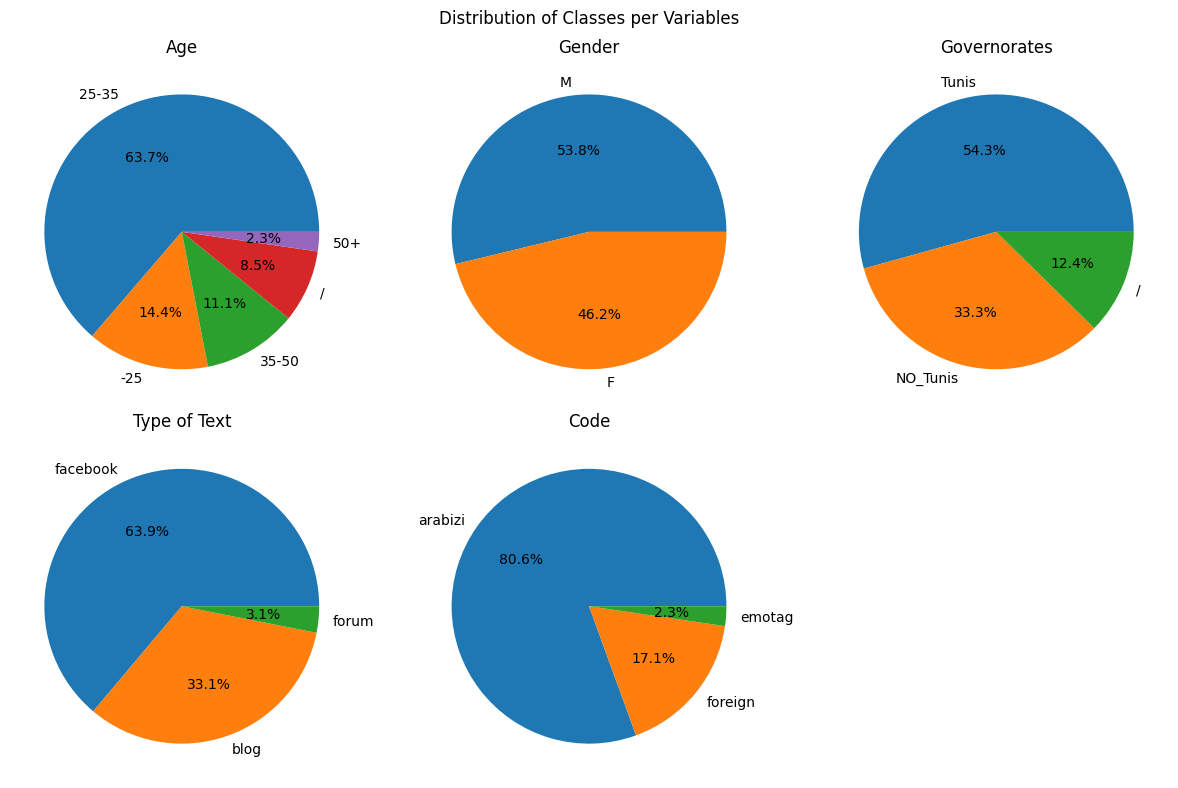

In [3]:
# Creazione del grafico a torta per tutte le variabili
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Distribution of Classes per Variables')

# Distribuzione della variabile 'AGE_RANGE'
age_counts = data['AGE_RANGE'].value_counts()
axs[0, 0].pie(age_counts.values, labels=age_counts.index, autopct='%1.1f%%')
axs[0, 0].set_title('Age')

# Distribuzione della variabile 'GENDER'
gender_counts = data['GENDER'].value_counts()
axs[0, 1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
axs[0, 1].set_title('Gender')

# Distribuzione della variabile 'GOVERNORATE'
gov_counts = data['GOVERNORATE'].value_counts()
axs[0, 2].pie(gov_counts.values, labels=gov_counts.index, autopct='%1.1f%%')
axs[0, 2].set_title('Governorates')

# Distribuzione della variabile 'TYPE'
type_counts = data['TYPE'].value_counts()
axs[1, 0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
axs[1, 0].set_title('Type of Text')

# Distribuzione della variabile 'CODE'
code_counts = data['CODE'].value_counts()
axs[1, 1].pie(code_counts.values, labels=code_counts.index, autopct='%1.1f%%')
axs[1, 1].set_title('Code')

# Rimuovi l'ultimo asse inutilizzato
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()


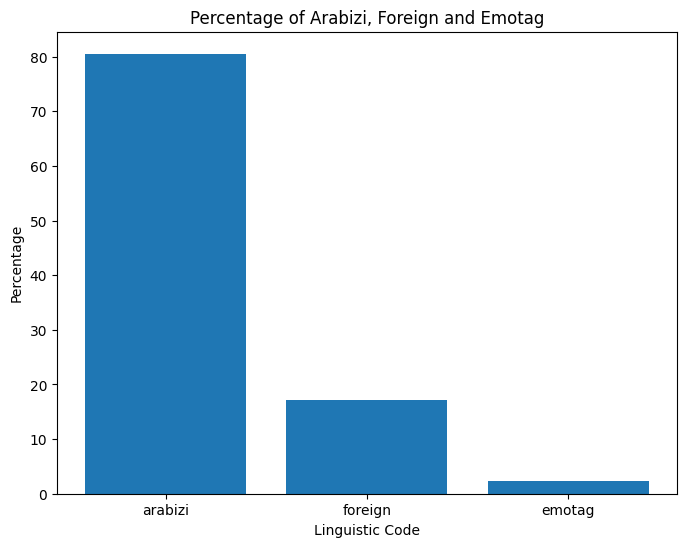

In [4]:
# Creazione del grafico a barre per la variabile 'CODE'
code_labels = ['arabizi', 'foreign', 'emotag']
code_counts = data[data['CODE'].isin(code_labels)]['CODE'].value_counts()
code_percentages = code_counts / code_counts.sum() * 100

plt.figure(figsize=(8, 6))
plt.bar(code_labels, code_percentages)
plt.title('Percentage of Arabizi, Foreign and Emotag')
plt.xlabel('Linguistic Code')
plt.ylabel('Percentage')
plt.show()

In [5]:
# Separazione delle variabili indipendenti e dipendente
X = data[['TYPE', 'GOVERNORATE', 'AGE_RANGE', 'GENDER']]
y = data[['CODE']]

# Encoding delle variabili categoriche
le = LabelEncoder()
X['GENDER'] = le.fit_transform(X['GENDER'])
X['GOVERNORATE'] = le.fit_transform(X['GOVERNORATE'])
X['AGE_RANGE'] = le.fit_transform(X['AGE_RANGE'])
X['TYPE'] = le.fit_transform(X['TYPE'])


# Encoding della variabile dipendente
y = le.fit_transform(data['CODE'])

# Converti tutti i nomi delle colonne in stringhe
X.columns = X.columns.astype(str)
X

<ipython-input-5-a671fdc569a8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['GENDER'] = le.fit_transform(X['GENDER'])
<ipython-input-5-a671fdc569a8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['GOVERNORATE'] = le.fit_transform(X['GOVERNORATE'])
<ipython-input-5-a671fdc569a8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,TYPE,GOVERNORATE,AGE_RANGE,GENDER
0,2,2,2,0
1,2,2,2,0
2,2,2,2,0
3,2,2,2,0
4,2,2,2,0
...,...,...,...,...
23350,0,2,2,1
23351,0,2,2,1
23352,0,2,2,1
23353,0,2,2,1


In [6]:
# Suddivisione dei dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_test))

16198
4050


In [7]:
# Creazione e addestramento del modello di regressione logistica
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)


LogisticRegression(multi_class='multinomial')

E' stato valutato l'uso dell'argomento class_weight nel costruttore del modello per specificare i pesi da assegnare alle diverse classi durante il calcolo della funzione di perdita, visto che i dati non sono bilanciati.
La scelta dei pesi dipende dalla distribuzione delle classi nel set di dati (foreign: 17.1%, emotag: 2.3%, arabizi:80.6%). La questione va approfondita.

In [8]:
# Esegui la cross-validation
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')

# Stampa i risultati
print("Accuracy media: {:.2f}".format(scores.mean()))
print("Deviazione standard: {:.2f}".format(scores.std()))

Accuracy media: 0.80
Deviazione standard: 0.00


È importante tenere presente che l'accuratezza da sola potrebbe non fornire una misura completa delle prestazioni del modello, specialmente se i dati sono sbilanciati o se ci sono classi con un numero molto ridotto di campioni. Pertanto, potresti voler considerare anche altre metriche di valutazione come la precisione, il richiamo, l'F1-score o l'area sotto la curva ROC per ottenere una valutazione più completa delle prestazioni del modello.

In [9]:
# Valutazione del modello sul test-set
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))


              precision    recall  f1-score   support

           0       0.81      0.99      0.89      3271
           1       1.00      0.00      0.00       100
           2       0.28      0.03      0.05       679

    accuracy                           0.80      4050
   macro avg       0.70      0.34      0.31      4050
weighted avg       0.73      0.80      0.73      4050



In [10]:
# Creazione dell'istanza del modello di regressione logistica
lr = LogisticRegression(solver='newton-cg')

# Definizione del range per i pesi delle classi
weights = np.linspace(0.1, 0.9, 5)

# Creazione del dizionario per la griglia dei parametri
param_grid = {'class_weight': [{0: x, 1: 1.0 - x} for x in weights]}

# Esecuzione della Grid Search con 5 fold di validazione incrociata
gridsearch = GridSearchCV(estimator=lr,
                          param_grid=param_grid,
                          cv=StratifiedKFold(),
                          n_jobs=-1,
                          scoring='f1',
                          verbose=2)

# Addestramento del modello sulla griglia dei parametri
gridsearch.fit(X_train, y_train)

# Creazione del DataFrame per i risultati
weight_data = pd.DataFrame({'score': gridsearch.cv_results_['mean_test_score'],
                            'weight': (1 - weights)})

# Plot del punteggio per i diversi valori di peso
# sns.set_style('whitegrid')
# plt.figure(figsize=(8, 6))
# sns.lineplot(weight_data['weight'])
# plt.xlabel('Peso per la classe 1')
# plt.ylabel('Punteggio F1')
# plt.xticks([round(i / 10, 1) for i in range(0, 11, 1)])
# plt.title('Punteggio per diversi pesi delle classi', fontsize=24)
# plt.show()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


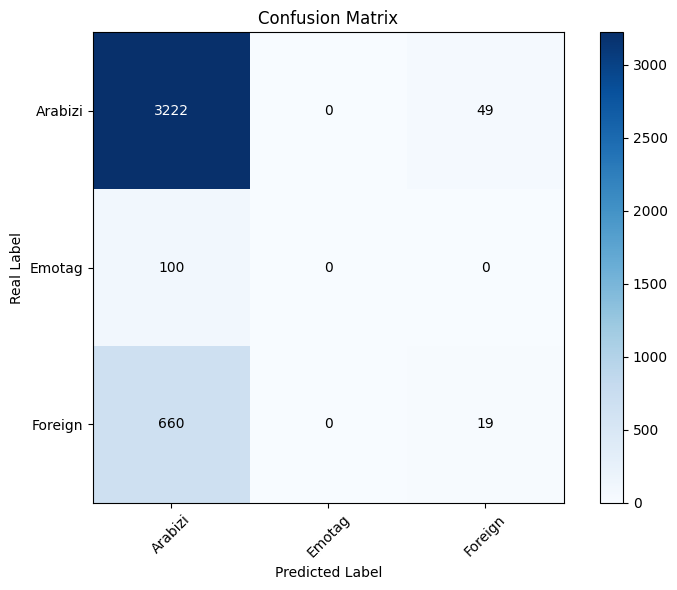

In [12]:
# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Definisci le etichette delle classi
class_labels = ['Arabizi', 'Emotag', 'Foreign']

# Crea il grafico della matrice di confusione
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('Real Label')

# Aggiungi i valori numerici alla matrice di confusione
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

**La matrice di confusione fornisce informazioni sulla correttezza delle previsioni del modello per ciascuna classe.**

1.   La prima riga rappresenta la classe reale "Arabizi".
2.   La seconda riga rappresenta la classe reale "Emotag".
3.   La terza riga rappresenta la classe reale "Foreign".
1.   La prima colonna rappresenta la classe predetta come "Arabizi".
2.   La seconda colonna rappresenta la classe predetta come "Emotag".
3.   La terza colonna rappresenta la classe predetta come "Foreign".

Riguardo ai valori specifici all'interno della matrice:

Nella cella in alto a sinistra, il valore 3222 indica che ci sono stati 3222 casi in cui la classe reale era "Arabizi" e il modello ha predetto correttamente "Arabizi".

Nella cella centrale, della riga "Arabizi", il valore 0 indica che non ci sono stati casi in cui la classe reale era "Arabizi", ma il modello ha erroneamente predetto "Emotag".

Nella cella a destra, della riga "Arabizi", il valore 49 indica che ci sono stati 49 casi in cui la classe reale era "Arabizi", ma il modello ha erroneamente predetto "Foreign".

Nella cella centrale della riga "Emotag", il valore 100 indica che ci sono stati 100 casi in cui la classe reale era "Emotag" e il modello ha predetto correttamente "Emotag".

Nelle altre celle nella riga "Emotag" (prima colonna e ultima colonna), tutti i valori sono 0. Ciò indica che non ci sono stati casi in cui il modello ha predetto erroneamente "Emotag" per le altre classi.

Nella cella a sinistra della riga "Foreign", il valore 660 indica che ci sono stati 660 casi in cui la classe reale era "Foreign" e il modello ha predetto correttamente "Foreign".

Nella cella a destra della riga "Foreign", il valore 19 indica che ci sono stati 19 casi in cui la classe reale era "Foreign", ma il modello ha erroneamente predetto "Arabizi".

*La mancanza di valori diversi da zero nelle predizioni errate per alcune classi può essere dovuta a un bilanciamento dei dati o a una mancanza di esempi rappresentativi per quelle classi nel set di dati utilizzato per la valutazione del modello.*

             TYPE  GOVERNORATE  AGE_RANGE    GENDER
Arabizi -0.996468    -0.388884   0.045279  0.328205
Emotag   0.677415     0.108817  -0.354189  0.545256
Foreign  0.319053     0.280067   0.308910 -0.873461


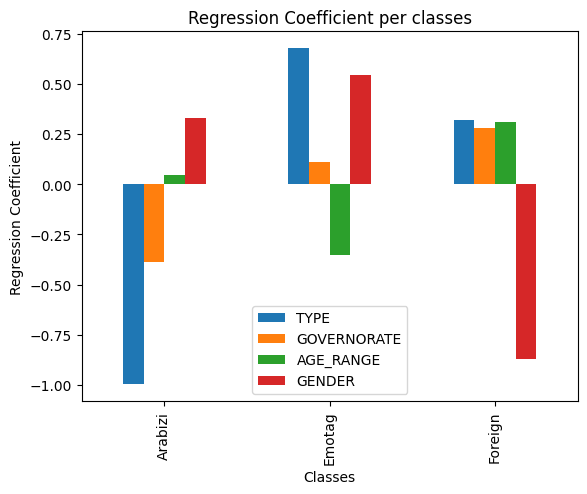

In [13]:
# Estrazione dei coefficienti di regressione
coefficients = model.coef_

# Creazione della tabella dei coefficienti
coefficients_table = pd.DataFrame(coefficients, columns=X.columns, index=class_labels) #model.classes_)
print(coefficients_table)

# Visualizzazione dei coefficienti come grafico a barre
coefficients_table.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Regression Coefficient')
plt.title('Regression Coefficient per classes')
plt.legend(loc='best')
plt.show()

# Calcolo delle probabilità previste
#predicted_probabilities = model.predict_proba(X_test)

# Creazione di un DataFrame per le probabilità previste
#predicted_probabilities_table = pd.DataFrame(predicted_probabilities, columns=class_labels)#model.classes_)
#print(predicted_probabilities_table)

Per quanto riguarda la prima tabella:

I risultati della tabella rappresentano i coefficienti di regressione prodotti da un modello di regressione logistica multinomiale. Questo tipo di modello è utilizzato per analizzare le relazioni tra una variabile dipendente categorica e più variabili indipendenti.

Le variabili indipendenti presenti nel modello sono "TYPE" (genere testuale), "GOVERNORATE" (governatorato), "AGE_RANGE" (intervallo di età) e "GENDER" (genere sessuale). La variabile dipendente è la codifica di scrittura in tre classi: "ARABIZI", "FOREIGN" e "EMOTAG".

I coefficienti di regressione indicano l'effetto di ciascuna variabile indipendente sulla variabile dipendente, tenendo conto delle altre variabili nel modello.


Ecco una descrizione aggiornata dei risultati per ciascuna variabile:

**TYPE** (Tipo di contesto testuale: Blog, Forum, Facebook):
Un coefficiente di -0.996468 per la classe "Arabizi" indica che il tipo di contesto testuale ha un forte effetto negativo sulla probabilità di appartenenza a questa classe (Arabizi) rispetto alle altre classi (Foreign, Emotag). Ciò implica che le scritture in stile Arabizi sono meno comuni o meno probabili in questi contesti rispetto alle altre scritture.
Un coefficiente di 0.677415 per la classe "Emotag" indica che il tipo di contesto testuale ha un effetto positivo sulla probabilità di appartenenza a questa classe rispetto alle altre classi. Ciò suggerisce che gli Emotag sono più comuni o più probabili in determinati contesti testuali.
Un coefficiente di 0.319053 per la classe "Foreign" indica che il tipo di contesto testuale ha un effetto positivo sulla probabilità di appartenenza a questa classe rispetto alle altre classi. Questo suggerisce che il Code-Mixing è più comune o più probabile in determinati contesti testuali.

**GOVERNORATE** (Governatorato:Tunisi, non-Tunisi, non-dichiarato):
Un coefficiente di -0.388884 per la classe "Arabizi" indica che il governatorato ha un effetto negativo sulla probabilità di appartenenza a questa classe rispetto alle altre classi. Questo potrebbe significare che alcune aree geografiche hanno una minore tendenza a utilizzare la scrittura in stile Arabizi.
Un coefficiente di 0.108817 per la classe "Emotag" indica che il governatorato ha un effetto positivo sulla probabilità di appartenenza a questa classe rispetto alle altre classi. Ciò implica che alcune aree geografiche potrebbero avere una maggiore propensione a utilizzare la scrittura in stile Emotag.
Un coefficiente di 0.280067 per la classe "Foreign" indica che il governatorato ha un effetto positivo sulla probabilità di appartenenza a questa classe rispetto alle altre classi. Questo suggerisce che alcune aree geografiche potrebbero avere una maggiore tendenza a utilizzare la scrittura in stile Foreign.

**AGE_RANGE** (Intervallo di età: -25, 25-35, 35-50, +50, non-dichiarato):
Un coefficiente di 0.045279 per la classe "Arabizi" indica che l'intervallo di età ha un effetto positivo molto piccolo sulla probabilità di appartenenza a questa classe rispetto alle altre classi.
Un coefficiente di -0.354189 per la classe "Emotag" indica che l'intervallo di età ha un effetto negativo sulla probabilità di appartenenza a questa classe rispetto alle altre classi.
Un coefficiente di 0.308910 per la classe "Foreign" indica che l'intervallo di età ha un effetto positivo sulla probabilità di appartenenza a questa classe rispetto alle altre classi.

**GENDER** (Genere: M, F):
Un coefficiente di 0.328205 per la classe "Arabizi" indica che il genere ha un effetto positivo sulla probabilità di appartenenza a questa classe rispetto alle altre classi.
Un coefficiente di 0.545256 per la classe "Emotag" indica che il genere ha un effetto positivo sulla probabilità di appartenenza a questa classe rispetto alle altre classi.
Un coefficiente di -0.873461 per la classe "Foreign" indica che il genere ha un effetto negativo sulla probabilità di appartenenza a questa classe rispetto alle altre classi.

*Tuttavia, è importante notare che i dati non sono molto bilanciati, il che significa che potrebbero esserci delle distorsioni o delle limitazioni nella generalizzazione dei risultati.*

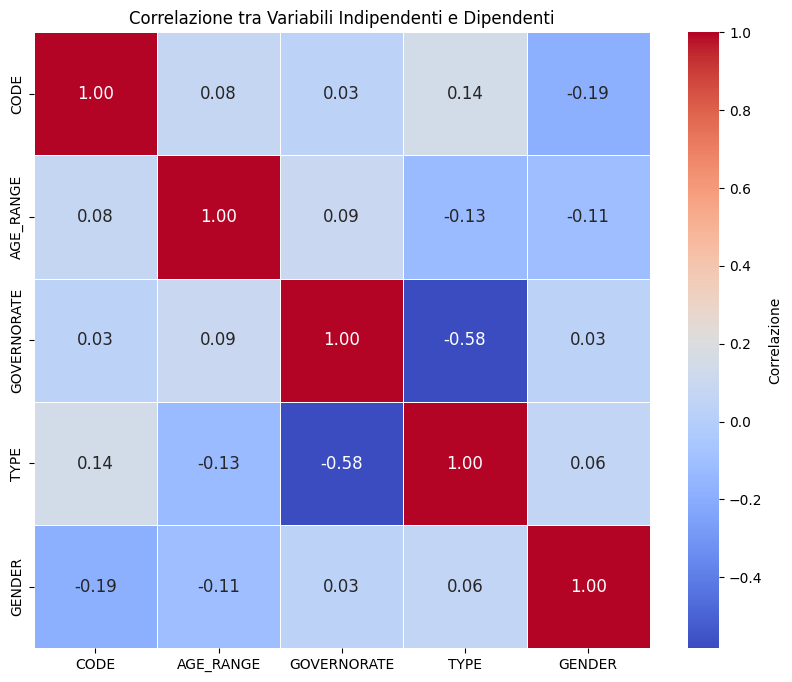

In [15]:
#HEATMAP

# Crea un DataFrame con le variabili indipendenti e dipendenti
data = pd.DataFrame({
    'CODE': y,
    'AGE_RANGE': X['AGE_RANGE'],
    'GOVERNORATE': X['GOVERNORATE'],
    'TYPE': X['TYPE'],
    'GENDER': X['GENDER']
})

# Definisci le classi per ciascuna variabile
classi_variabile = {
    'CODE': ['<eos>', 'arabizi', 'emotag', 'foreign'],
    'AGE_RANGE': ['-25', '/', '25-35', '35-50', '50+', '<eos>'],
    'GOVERNORATE': ['/', '<eos>', 'Europe', 'NO_Tunis', 'Texas', 'Tunis', 'Équateur'],
    'TYPE': ['<eos>', 'blog', 'facebook', 'forum'],
    'GENDER': ['<eos>', 'F', 'M']
}

# Crea una mappa di colori personalizzata basata sulle classi delle variabili
color_map = {
    'CODE': ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral'],
    'AGE_RANGE': ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightsalmon', 'lightpink'],
    'GOVERNORATE': ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightsalmon', 'lightpink', 'lightgray'],
    'TYPE': ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral'],
    'GENDER': ['lightblue', 'lightgreen', 'lightyellow']
}

# Calcola la matrice di correlazione
corr_matrix = data.corr()

# Crea il grafico della heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar=True, square=True, annot_kws={"size": 12},
            xticklabels=data.columns, yticklabels=data.columns,
            cbar_kws={'label': 'Correlazione'})


# Colora le celle della heatmap in base alle classi delle variabili
for i in range(len(data.columns)):
    for j in range(len(data.columns)):
        if data.columns[i] != data.columns[j]:
            classe_variabile_i = data.columns[i]
            classe_variabile_j = data.columns[j]
            if classe_variabile_i in classi_variabile and classe_variabile_j in classi_variabile:
                valori_variabile_i = data[classe_variabile_i].unique()
                valori_variabile_j = data[classe_variabile_j].unique()
                if len(valori_variabile_i) == 1 and len(valori_variabile_j) == 1:
                    classe_variabile_i = valori_variabile_i[0]
                    classe_variabile_j = valori_variabile_j[0]
                    if classe_variabile_i in classi_variabile[classe_variabile_i] and classe_variabile_j in classi_variabile[classe_variabile_j]:
                        color_variabile_i = color_map[classe_variabile_i][classi_variabile[classe_variabile_i].index(classe_variabile_i)]
                        color_variabile_j = color_map[classe_variabile_j][classi_variabile[classe_variabile_j].index(classe_variabile_j)]
                        plt.text(j + 0.5, i + 0.5, corr_matrix.iloc[i, j].round(2),
                                 horizontalalignment='center', verticalalignment='center',
                                 color=color_variabile_i if color_variabile_i == color_variabile_j else 'white')

plt.title('Correlazione tra Variabili Indipendenti e Dipendenti')
plt.show()


Contingency Table between GENDER and CODE:
CODE        0    1     2    All
GENDER                         
0        6847  151  2362   9360
1        9464  317  1107  10888
All     16311  468  3469  20248



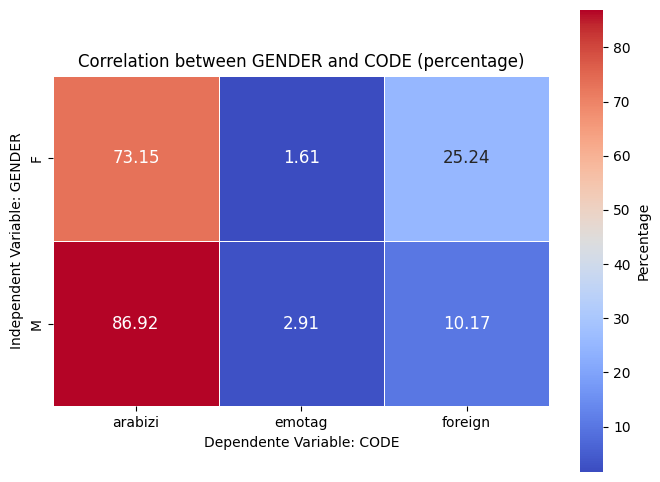

In [16]:
# Mappa delle classi per la variabile 'CODE'
classi_code = ['arabizi', 'emotag', 'foreign']

# Mappa delle classi per la variabile 'GENDER'
classi_gender = ['F', 'M']

# Calcola la tabella di contingenza tra 'GENDER' e 'CODE'
contingency_table = pd.crosstab(data['GENDER'], data['CODE'], margins=True)

# Calcola la tabella di contingenza normalizzata in percentuale
normalized_contingency = contingency_table.apply(lambda x: x / x.loc['All'] * 100, axis=1)

# Stampa la tabella di contingenza con i totali
print("Contingency Table between GENDER and CODE:")
print(contingency_table)
print()

# Rimuovi la riga e colonna dei totali per il calcolo della heatmap
normalized_contingency = normalized_contingency.iloc[:-1, :-1]

# Crea il grafico della heatmap per 'GENDER' e 'CODE' con i valori normalizzati
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_contingency, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar=True, square=True, annot_kws={"size": 12},
            xticklabels=classi_code, yticklabels=classi_gender,
            cbar_kws={'label': 'Percentage'})


plt.title('Correlation between GENDER and CODE (percentage)')
plt.xlabel('Dependente Variable: CODE')
plt.ylabel('Independent Variable: GENDER')
plt.show()


Nel codice sopra, ho calcolato la tabella di contingenza normalizzata utilizzando div() per dividere ogni valore della tabella di contingenza per la somma totale di tutti i valori. Poi, ho utilizzato i valori normalizzati nella heatmap, specificando fmt=".2%" per formattare i valori come percentuali con due decimali.

Contingency Table between AGE RANGE and CODE:
CODE           0    1     2    All
AGE_RANGE                         
0           2504  188   215   2907
1           1277   15   439   1731
2          10454  237  2207  12898
3           1785   25   440   2250
4            291    3   168    462
All        16311  468  3469  20248



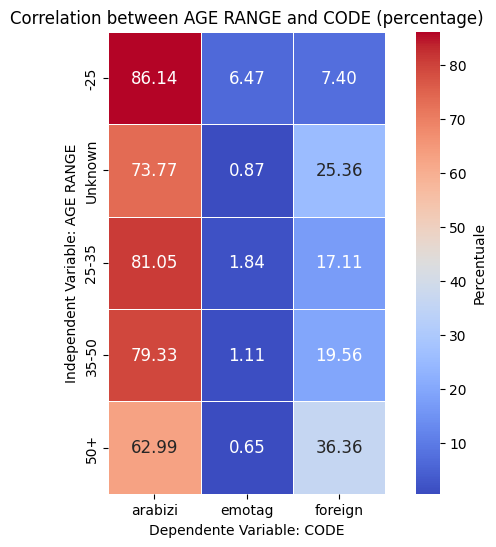

In [17]:
# Mappa delle classi per la variabile 'CODE'
classi_code = ['arabizi', 'emotag', 'foreign']

# Mappa delle classi per la variabile 'AGE_RANGE'
classi_age = ['-25', 'Unknown', '25-35', '35-50', '50+']

# Calcola la tabella di contingenza tra 'AGE_RANGE' e 'CODE'
contingency_table = pd.crosstab(data['AGE_RANGE'], data['CODE'], margins=True)

# Calcola la tabella di contingenza normalizzata in percentuale
normalized_contingency = contingency_table.apply(lambda x: x / x.loc['All'] * 100, axis=1)

# Stampa la tabella di contingenza con i totali
print("Contingency Table between AGE RANGE and CODE:")
print(contingency_table)
print()

# Rimuovi la riga e colonna dei totali per il calcolo della heatmap
normalized_contingency = normalized_contingency.iloc[:-1, :-1]

# Crea il grafico della heatmap per 'AGE_RANGE' e 'CODE' con i valori normalizzati
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_contingency, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar=True, square=True, annot_kws={"size": 12},
            xticklabels=classi_code, yticklabels=classi_age,
            cbar_kws={'label': 'Percentuale'})

plt.title('Correlation between AGE RANGE and CODE (percentage)')
plt.xlabel('Dependente Variable: CODE')
plt.ylabel('Independent Variable: AGE RANGE')
plt.show()


Contingency Table between GOVERNORATE and CODE:
CODE             0    1     2    All
GOVERNORATE                         
0             2127   35   341   2503
1             5368  239  1142   6749
2             8816  194  1986  10996
All          16311  468  3469  20248



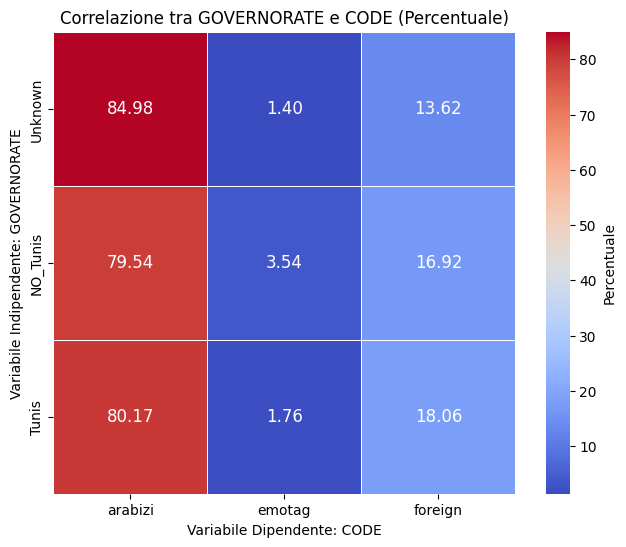

In [18]:
# Mappa delle classi per la variabile 'CODE'
classi_code = ['arabizi', 'emotag', 'foreign']

# Mappa delle classi per la variabile 'GOVERNORATE'
classi_gov = ['Unknown', 'NO_Tunis', 'Tunis']

# Calcola la tabella di contingenza tra 'GOVERNORATE' e 'CODE'
contingency_table = pd.crosstab(data['GOVERNORATE'], data['CODE'], margins=True)

# Calcola la tabella di contingenza normalizzata in percentuale
normalized_contingency = contingency_table.apply(lambda x: x / x.loc['All'] * 100, axis=1)

# Stampa la tabella di contingenza con i totali
print("Contingency Table between GOVERNORATE and CODE:")
print(contingency_table)
print()

# Rimuovi la riga e colonna dei totali per il calcolo della heatmap
normalized_contingency = normalized_contingency.iloc[:-1, :-1]

# Crea il grafico della heatmap per 'GOVERNORATE' e 'CODE' con i valori normalizzati
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_contingency, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar=True, square=True, annot_kws={"size": 12},
            xticklabels=classi_code, yticklabels=classi_gov,
            cbar_kws={'label': 'Percentuale'})

plt.title('Correlazione tra GOVERNORATE e CODE (Percentuale)')
plt.xlabel('Variabile Dipendente: CODE')
plt.ylabel('Variabile Indipendente: GOVERNORATE')
plt.show()

Contingency Table between TYPE and CODE:
CODE      0    1     2    All
TYPE                         
0      5978    7   707   6692
1      9876  458  2595  12929
2       457    3   167    627
All   16311  468  3469  20248



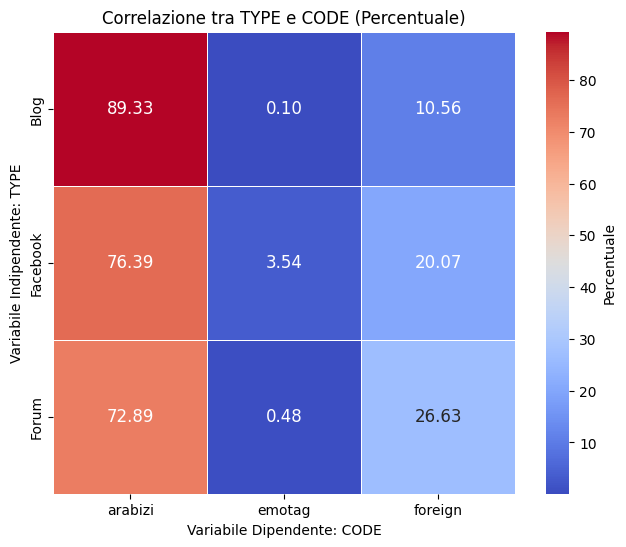

In [19]:
# Mappa delle classi per la variabile 'CODE'
classi_code = ['arabizi', 'emotag', 'foreign']

# Mappa delle classi per la variabile 'TYPE'
classi_typ = ['Blog', 'Facebook', 'Forum']

# Calcola la tabella di contingenza tra 'TYPE' e 'CODE'
contingency_table = pd.crosstab(data['TYPE'], data['CODE'], margins=True)

# Calcola la tabella di contingenza normalizzata in percentuale
normalized_contingency = contingency_table.apply(lambda x: x / x.loc['All'] * 100, axis=1)

# Stampa la tabella di contingenza con i totali
print("Contingency Table between TYPE and CODE:")
print(contingency_table)
print()

# Rimuovi la riga e colonna dei totali per il calcolo della heatmap
normalized_contingency = normalized_contingency.iloc[:-1, :-1]

# Crea il grafico della heatmap per 'TYPE' e 'CODE' con i valori normalizzati
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_contingency, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar=True, square=True, annot_kws={"size": 12},
            xticklabels=classi_code, yticklabels=classi_typ,
            cbar_kws={'label': 'Percentuale'})

plt.title('Correlazione tra TYPE e CODE (Percentuale)')
plt.xlabel('Variabile Dipendente: CODE')
plt.ylabel('Variabile Indipendente: TYPE')
plt.show()

